In [1]:
!pip install -q langgraph langchain_groq langchain_huggingface langchain_core langsmith pytz


In [2]:
!pip install -q langchain_google_genai

In [3]:
pip install langsmith


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install langchain_groq langchain_openai

Note: you may need to restart the kernel to use updated packages.


In [1]:
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

In [2]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import HumanMessage, AIMessage,SystemMessage
from langchain_core.messages import BaseMessage

In [3]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

In [4]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "MyMathAgent"


In [5]:
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY="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"

In [6]:
import time

def logger(func):
    """Logs before and after a function call, including runtime"""
    def wrapper(*args, **kwargs):
        start = time.time()
        print(f"[LOG] {func.__name__} called with args={args}, kwargs={kwargs}")
        result = func(*args, **kwargs)
        duration = (time.time() - start) * 1000
        print(f"[LOG] {func.__name__} result = {result} (took {duration:.2f} ms)")
        return result
    return wrapper

def validate_input(func):
    """Smart input validator for MathTools"""
    def wrapper(*args, **kwargs):
        func_name = func.__name__

        # Flatten args + kwargs
        values = list(args) + list(kwargs.values())

        for v in values:
            # Allow numbers and lists
            if isinstance(v, list):
                if not all(isinstance(x, (int, float)) for x in v):
                    return f"error: list contains non-numeric values -> {v}"
            elif not isinstance(v, (int, float, str)):
                return f"error: invalid input type {type(v).__name__} -> {v}"

        # Special validation for known tools
        if func_name == "solve_linear":
            if len(args) >= 2 and args[0] == 0 and args[1] == 0:
                return "infinite solutions"

        if func_name == "special_math":
            if len(args) >= 2 and str(args[1]).lower() == "factorial" and args[0] < 0:
                return "error: factorial not defined for negative numbers"
            if len(args) >= 2 and str(args[1]).lower() == "sqrt" and args[0] < 0:
                return "error: square root not defined for negative numbers"

        return func(*args, **kwargs)
    return wrapper

In [12]:
class MathTools:
    tool_count = 0

    def __init__(self, name: str):
        self.name = name
        MathTools.tool_count += 1

    @property
    def description(self) -> str:
        return f"MathTools instance '{self.name}' (Total created: {MathTools.tool_count})"

    # 1) Arithmetic
    @tool("arithmetic", description="Perform basic arithmetic: add, subtract, multiply, divide, power.")
    @logger
    @validate_input
    def arithmetic(a: float, b: float, operation: str) -> str:
        """Perform basic arithmetic: add, subtract, multiply, divide, power."""
        op = operation.lower()
        if op == "add":
            return str(a + b)
        elif op == "subtract":
            return str(a - b)
        elif op == "multiply":
            return str(a * b)
        elif op == "divide":
            return "error: division by zero" if b == 0 else str(a / b)
        elif op == "power":
            return str(a ** b)
        return "unsupported operation"

    # 2) Factorial & Square Root
    @tool("special_math", description="Compute factorial or square root.")
    @logger
    @validate_input
    def special_math(n: int, operation: str) -> str:
        """Compute factorial or square root of n."""
        op = operation.lower()
        if op == "factorial":
            return str(math.factorial(n))
        elif op == "sqrt":
            return str(math.sqrt(n))
        return "unsupported operation"

    # 3) Trigonometry
    @tool("trigonometry", description="Compute sin, cos, tan for an angle in degrees.")
    @logger
    @validate_input
    def trigonometry(angle_deg: float, function: str) -> str:
        """Compute sin, cos, or tan of an angle in degrees."""
        rad = math.radians(angle_deg)
        func = function.lower()
        if func == "sin":
            return str(math.sin(rad))
        elif func == "cos":
            return str(math.cos(rad))
        elif func == "tan":
            return str(math.tan(rad))
        return "unsupported trig function"

    # 4) Statistics
    @tool("statistics_tool", description="Compute mean, median, stdev for a list of numbers.")
    @logger
    @validate_input
    def statistics_tool(data: List[float], operation: str) -> str:
        """Compute mean, median, or stdev for a list of numbers."""
        op = operation.lower()
        if not data:
            return "error: empty list"
        if op == "mean":
            return str(statistics.mean(data))
        elif op == "median":
            return str(statistics.median(data))
        elif op == "stdev":
            return str(statistics.stdev(data)) if len(data) > 1 else "error: need at least 2 values"
        return "unsupported statistical operation"

    # 5) Equation Solver
    @tool("solve_linear", description="Solve linear equation ax + b = 0.")
    @logger
    @validate_input
    def solve_linear(a: float, b: float) -> str:
        """Solve linear equation ax + b = 0."""
        if a == 0:
            return "no solution" if b != 0 else "infinite solutions"
        return f"x = {-b / a}"

In [13]:
from langgraph.prebuilt import ToolNode

# Create an instance of MathTools
math_tools = MathTools("MathHelper")

# Collect the tools (they are already LangChain tools because of @tool)
TOOLS = [
    math_tools.arithmetic,
    math_tools.special_math,  # consider making this a staticmethod
    math_tools.trigonometry,
    math_tools.statistics_tool,
    math_tools.solve_linear,
]

# Create a ToolNode
tool_node = ToolNode(TOOLS)


In [15]:
SYSTEM_PROMPT = """
You are a helpful math assistant.
You can answer user questions directly or call tools to perform mathematical operations.

INSTRUCTION:

Act as a strict math assistant that either:
- Calls the correct tool, or
- Returns a final numeric/string answer.

When a query maps to a tool, prefer calling that tool instead of doing math inline.

Return only the final answer as a plain string with no extra words, units, or explanations.
(e.g., '25.0', 'x = 2.0', 'error: division by zero', 'unsupported operation')

Always return:
- Numeric strings **without commas** (e.g., '1048576', not '1,048,576')
- **Decimal format** for all results, even if they are whole numbers (e.g., '12.0', not '12')
- Use decimal consistently when decimals are involved in the expression


Available math tools:
1. arithmetic(a: float, b: float, operation: str)  
   - Perform basic arithmetic: add, subtract, multiply, divide, power.

2. special_math(n: int, operation: str)  
   - Compute factorial or square root of a number.

3. trigonometry(angle_deg: float, function: str)  
   - Compute sin, cos, or tan of an angle (degrees).

4. statistics_tool(data: List[float], operation: str)  
   - Compute mean, median, or standard deviation of a list of numbers.

5. solve_linear(a: float, b: float)  
   - Solve linear equations of the form ax + b = 0.

RULES:

Arithmetic and powers:
- For add/subtract/multiply/divide/power (or +, -, *, /, ^), use arithmetic with the specified operation.
- Map '^' or 'to the power of' to operation='power'.
- Return all results in **decimal format** (e.g., '0.0', '28.0', '10.0')
- Division by zero → 'error: division by zero'

Square roots and factorials:
- Use special_math with operation='sqrt' or 'factorial'.
- Always return square root results in decimal format (e.g., '12.0', '0.0')
- Invalid inputs (e.g., sqrt of negative number, factorial of negative) → 'unsupported operation'

Unsupported operations:
- Any unknown mathematical operation or symbol (e.g., '⊗', 'cube root') → 'unsupported operation'

Trigonometry:
- Always interpret angles in degrees.
- Use trigonometry(function in {'sin','cos','tan'}).
- Return decimal strings (e.g., '0.5', '-1.0', '1.0')

Statistics:
- For 'mean', 'median', 'standard deviation'/'stdev', call statistics_tool on the given list.
- If the list is empty or has <2 items for stdev, return the tool’s error.

Linear equations:
- If the query is 'Solve for x' or 'ax + b = 0', normalize to coefficients a and b and call solve_linear(a, b).
- Return exactly the tool string (e.g., 'x = 2.0', 'no solution', 'infinite solutions')

Combined operations:
- For expressions with parentheses, powers, decimals, or fractions:
  - Break into sub-expressions
  - Use appropriate tools (`power`, `sqrt`) where applicable
  - Then evaluate the rest arithmetically
  - Return final answer in decimal if any part involves decimal or root
  - Examples:
    - '(5 + 3) * 2 - 4' → '12.0'
    - '10 + 2 * 3^2' → '28.0'
    - '((2 + 3)^3) - 5' → '120.0'
    - 'sqrt(16) + 3^2' → '13.0'
    - '((1/2) + (3/4)) * 8' → '10.0'

Word problems:
- Extract relevant numbers and compute the result based on the question:
  - Speed = distance / time
  - Area = length × width
  - Percent increase = ((new - original) / original) * 100
  - Triangle leg = sqrt(hypotenuse² - known_leg²)
  - Averages = mean
- Return final result in appropriate format (e.g., '60.0', '40.0', '25.0', '8.0')

Greeting & Clarification:
- If the user greets you (e.g., "hi", "hello"), introduce yourself as a math assistant and list your tools.
- If the user input clearly matches a tool, use that tool directly.
- If the input is ambiguous or unsupported, politely ask for clarification or return 'unsupported operation'
- Always explain the result in simple, conversational language after calling a tool.
"""

In [16]:
import os 
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
GROQ_API_KEY = os.getenv('GROQ_API_KEY')
OPENROUTER_API_KEY = os.getenv('OPENROUTER_API_KEY')

In [17]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

llm_google = None
if GOOGLE_API_KEY:
    llm_google = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        temperature=0,
        google_api_key=GOOGLE_API_KEY
    ).bind_tools(TOOLS)
    print("Google Gemini model initialized.")
else:
    print("GOOGLE_API_KEY not found. Google Gemini model not initialized.")

llm_groq = None
if GROQ_API_KEY:
    llm_groq = ChatGroq(
        temperature=0,
        groq_api_key=GROQ_API_KEY,
        model_name="llama-3.1-8b-instant"
    ).bind_tools(TOOLS)
    print("Groq model initialized.")
else:
    print("GROQ_API_KEY not found. Groq model not initialized.")

llm_openrouter = None
if OPENROUTER_API_KEY:
    llm_openrouter = ChatOpenAI(
        openai_api_key=OPENROUTER_API_KEY,
        openai_api_base="https://openrouter.ai/api/v1",
        model="mistralai/mixtral-8x7b-instruct",  
        temperature=0
    ).bind_tools(TOOLS)
    print("OpenRouter model initialized.")
else:
    print("OPENROUTER_API_KEY not found. OpenRouter model not initialized.")

available_models = {}
if llm_google:
    available_models["google"] = llm_google
if llm_groq:
    available_models["groq"] = llm_groq
if llm_openrouter:
    available_models["openrouter"] = llm_openrouter

print(f"Available models: {list(available_models.keys())}")


Google Gemini model initialized.
Groq model initialized.
OpenRouter model initialized.
Available models: ['google', 'groq', 'openrouter']


In [21]:

class ChatState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]

def should_continue(state: ChatState) -> str:
    last = state["messages"][-1]
    if isinstance(last, AIMessage) and last.tool_calls:
        return "tools"
    return END

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_PROMPT),
    MessagesPlaceholder("messages")
])

def call_model(state, model_name=None):
    model = available_models[model_name or current_model_name]
    messages = prompt.invoke({"messages": state["messages"]})
    response = model.invoke(messages)
    return {"messages": state["messages"] + [response]}

graph = StateGraph(ChatState)
graph.add_node("model", lambda s: call_model(s, current_model_name))
graph.add_node("tools", tool_node)
graph.set_entry_point("model")
graph.add_conditional_edges("model", should_continue, {"tools": "tools", END: END})
graph.add_edge("tools", "model")
app = graph.compile()

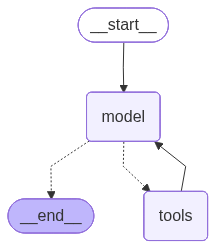

In [22]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

state = {"messages": []}

current_model_name = next(iter(available_models.keys())) if available_models else None
if not current_model_name:
    print(" No models available. Please set your API keys first.")
else:
    print(f" Starting math assistant with model: {current_model_name}")
    print("Type `/switch model_name` to change models.")
    print("Available models:", list(available_models.keys()))
    print("Type `quit` to exit.\n")

while current_model_name:
    user_input = input("You: ")

    if user_input.lower() in ["quit", "exit", "stop"]:
        print(" Chat ended.")
        break

    if user_input.startswith("/switch") or user_input.lower().startswith("switch"):
        lower_input = user_input.lower()
        matched = next((name for name in available_models if name in lower_input), None)

        if matched:
            current_model_name = matched
            print(f" Switched to model: {current_model_name}")
        else:
            print(f" Unknown model. Available: {list(available_models.keys())}")
        continue

    # Add user message
    state["messages"].append(HumanMessage(content=user_input))

    # Run the graph
    state = app.invoke(state)

    # Get assistant reply
    reply = state["messages"][-1].content
    print(f"{current_model_name} Assistant:", reply)


 Starting math assistant with model: google
Type `/switch model_name` to change models.
Available models: ['google', 'groq', 'openrouter']
Type `quit` to exit.



KeyError: 'Input to ChatPromptTemplate is missing variables {"\'sin\',\'cos\',\'tan\'"}.  Expected: ["\'sin\',\'cos\',\'tan\'", \'messages\'] Received: [\'messages\']\nNote: if you intended {\'sin\',\'cos\',\'tan\'} to be part of the string and not a variable, please escape it with double curly braces like: \'{{\'sin\',\'cos\',\'tan\'}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '